Task Outline:

 1. Extract attention maps for clean and adversarial examples.

 2. For each example, layer, and head, compute the persistence diagram of the attention graph (using the symmetrized attention matrix and converting to distance matrix).

 3. For each layer and head, compute the average bottleneck distance between the clean and adversarial examples.

 4. Visualize the results per layer and head.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from typing import List, Dict, Tuple, Optional
import pandas as pd
from scipy import stats
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import gudhi as gd
from persim import plot_diagrams
import pickle
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [4]:
class AdversarialAttentionAnalyzer:
    """
    Comprehensive analyzer for studying adversarial effects on LLM attention mechanisms
    """
    
    def __init__(self, model_name: str = "bert-base-uncased", device: str = None):
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        self.model_name = model_name
        
        # Initialize model and tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            
        try:
            self.model = AutoModel.from_pretrained(model_name, output_attentions=True)
        except:
            self.model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions=True)
        
        self.model = self.model.to(self.device)
        self.model.eval()
        
        # Analysis storage
        self.results = {}
        self.attention_data = {}
        
    def generate_adversarial_texts(self, texts: List[str], 
                                 methods: List[str] = ['typo', 'synonym', 'insertion', 'deletion'],
                                 intensity: float = 0.1) -> Dict[str, List[str]]:
        """
        Generate adversarial examples using multiple perturbation strategies
        """
        adversarial_sets = {}
        
        for method in methods:
            adversarial_sets[method] = []
            for text in texts:
                if method == 'typo':
                    adversarial_sets[method].append(self._add_typos(text, intensity))
                elif method == 'synonym':
                    adversarial_sets[method].append(self._replace_synonyms(text, intensity))
                elif method == 'insertion':
                    adversarial_sets[method].append(self._insert_words(text, intensity))
                elif method == 'deletion':
                    adversarial_sets[method].append(self._delete_words(text, intensity))
                elif method == 'reorder':
                    adversarial_sets[method].append(self._reorder_words(text, intensity))
        
        return adversarial_sets
    
    def _add_typos(self, text: str, intensity: float) -> str:
        """Add character-level typos"""
        words = text.split()
        n_typos = max(1, int(len(text) * intensity))
        
        for _ in range(n_typos):
            if len(words) > 0:
                word_idx = np.random.randint(0, len(words))
                word = words[word_idx]
                if len(word) > 2:
                    char_idx = np.random.randint(0, len(word))
                    # Random typo operation: swap, delete, or insert
                    operation = np.random.choice(['swap', 'delete', 'insert'])
                    
                    if operation == 'swap' and len(word) > 1:
                        # Swap adjacent characters
                        swap_idx = min(char_idx, len(word)-2)
                        word = word[:swap_idx] + word[swap_idx+1] + word[swap_idx] + word[swap_idx+2:]
                    elif operation == 'delete' and len(word) > 1:
                        word = word[:char_idx] + word[char_idx+1:]
                    elif operation == 'insert':
                        random_char = chr(np.random.randint(97, 123))
                        word = word[:char_idx] + random_char + word[char_idx:]
                
                words[word_idx] = word
        
        return ' '.join(words)
    
    def _replace_synonyms(self, text: str, intensity: float) -> str:
        """Replace words with synonyms using WordNet"""
        try:
            from nltk.corpus import wordnet as wn
            import nltk
            
            words = text.split()
            n_replacements = max(1, int(len(words) * intensity))
            
            for _ in range(n_replacements):
                if len(words) > 0:
                    word_idx = np.random.randint(0, len(words))
                    word = words[word_idx].lower()
                    
                    synonyms = set()
                    for syn in wn.synsets(word):
                        for lemma in syn.lemmas():
                            synonym = lemma.name().replace('_', ' ')
                            if synonym != word and len(synonym.split()) == 1:
                                synonyms.add(synonym)
                    
                    if synonyms:
                        new_word = np.random.choice(list(synonyms))
                        words[word_idx] = new_word
            
            return ' '.join(words)
        except:
            return text  # Fallback if WordNet fails
    
    def _insert_words(self, text: str, intensity: float) -> str:
        """Insert random words"""
        words = text.split()
        n_insertions = max(1, int(len(words) * intensity))
        filler_words = ['the', 'a', 'and', 'or', 'but', 'very', 'quite', 'somewhat']
        
        for _ in range(n_insertions):
            if len(words) > 0:
                insert_idx = np.random.randint(0, len(words))
                insert_word = np.random.choice(filler_words)
                words.insert(insert_idx, insert_word)
        
        return ' '.join(words)
    
    def _delete_words(self, text: str, intensity: float) -> str:
        """Delete random words"""
        words = text.split()
        n_deletions = max(1, int(len(words) * intensity))
        
        for _ in range(n_deletions):
            if len(words) > 1:  # Keep at least one word
                delete_idx = np.random.randint(0, len(words))
                words.pop(delete_idx)
        
        return ' '.join(words)
    
    def _reorder_words(self, text: str, intensity: float) -> str:
        """Reorder words in the text"""
        words = text.split()
        if len(words) > 2:
            n_swaps = max(1, int(len(words) * intensity))
            
            for _ in range(n_swaps):
                idx1, idx2 = np.random.choice(len(words), 2, replace=False)
                words[idx1], words[idx2] = words[idx2], words[idx1]
        
        return ' '.join(words)
    
    def extract_attention_maps(self, texts: List[str], layer_idx: int = None, max_length: int = 128) -> Dict:
        """
        Extract attention maps from the model with consistent sequence lengths
        """
        attention_data = {
            'all_attention': [],  # All attention heads across layers
            'layer_attention': {},  # Attention organized by layer
            'token_pairs': [],  # Token pairs and their attention weights
            'cls_attention': []  # CLS token attention patterns
        }
        
        with torch.no_grad():
            for text in texts:
                # Use consistent max_length and padding for all texts
                inputs = self.tokenizer(text, return_tensors="pt", truncation=True, 
                                      max_length=max_length, padding='max_length').to(self.device)
                
                outputs = self.model(**inputs, output_attentions=True)
                attentions = outputs.attentions  # Tuple of layer attention tensors
                
                # Store all attention maps
                batch_attention = []
                for layer, attn in enumerate(attentions):
                    # attn shape: (batch_size, num_heads, seq_len, seq_len)
                    attn_matrix = attn[0].cpu().numpy()  # Remove batch dimension
                    batch_attention.append(attn_matrix)
                    
                    # Store by layer if requested
                    if layer_idx is None or layer == layer_idx:
                        if layer not in attention_data['layer_attention']:
                            attention_data['layer_attention'][layer] = []
                        attention_data['layer_attention'][layer].append(attn_matrix)
                
                attention_data['all_attention'].append(batch_attention)
                
                # Extract CLS token attention patterns
                cls_attention = self._extract_cls_attention(batch_attention)
                attention_data['cls_attention'].append(cls_attention)
                
                # Extract token pair attention
                token_pairs = self._extract_token_pairs(batch_attention, inputs, text)
                attention_data['token_pairs'].extend(token_pairs)
        
        return attention_data
    
    def _extract_cls_attention(self, attention_maps: List[np.ndarray]) -> Dict:
        """Extract attention patterns related to CLS token"""
        cls_attention = {}
        
        for layer, attn in enumerate(attention_maps):
            # Attention from CLS token to all other tokens (average across heads)
            cls_to_all = attn[:, 0, :].mean(axis=0)  # Average over heads
            # Attention from all tokens to CLS token
            all_to_cls = attn[:, :, 0].mean(axis=0)  # Average over heads
            
            cls_attention[layer] = {
                'cls_to_all': cls_to_all,
                'all_to_cls': all_to_cls
            }
        
        return cls_attention
    
    def _extract_token_pairs(self, attention_maps: List[np.ndarray], 
                           inputs: Dict, text: str) -> List[Dict]:
        """Extract attention weights for important token pairs"""
        tokens = self.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
        token_pairs = []
        
        # Focus on meaningful token pairs (excluding special tokens)
        special_tokens = [self.tokenizer.cls_token, self.tokenizer.sep_token, 
                         self.tokenizer.pad_token, '[CLS]', '[SEP]', '[PAD]']
        meaningful_tokens = [i for i, token in enumerate(tokens) 
                           if token not in special_tokens and not token.startswith('##')]
        
        if len(meaningful_tokens) < 2:
            return token_pairs
        
        for layer, attn in enumerate(attention_maps):
            # Average attention across heads
            avg_attn = attn.mean(axis=0)
            
            for i in range(len(meaningful_tokens)):
                for j in range(i+1, len(meaningful_tokens)):
                    token_i_idx = meaningful_tokens[i]
                    token_j_idx = meaningful_tokens[j]
                    
                    attention_weight = avg_attn[token_i_idx, token_j_idx]
                    
                    token_pairs.append({
                        'layer': layer,
                        'token_i': tokens[token_i_idx],
                        'token_j': tokens[token_j_idx],
                        'token_i_idx': token_i_idx,
                        'token_j_idx': token_j_idx,
                        'attention': attention_weight,
                        'text': text
                    })
        
        return token_pairs
    
    def compute_attention_metrics(self, clean_attention: Dict, adv_attention: Dict) -> Dict:
        """
        Compute quantitative metrics comparing clean and adversarial attention maps
        """
        metrics = {}
        
        # 1. Attention distribution changes
        metrics['distribution_changes'] = self._compare_attention_distributions(
            clean_attention, adv_attention)
        
        # 2. Attention entropy changes
        metrics['entropy_changes'] = self._compute_entropy_changes(
            clean_attention, adv_attention)
        
        # 3. Topological analysis of attention graphs
        metrics['topological_changes'] = self._analyze_attention_topology(
            clean_attention, adv_attention)
        
        # 4. Attention focus shifts
        metrics['focus_shifts'] = self._compute_focus_shifts(
            clean_attention, adv_attention)
        
        return metrics
    
    def _compare_attention_distributions(self, clean: Dict, adv: Dict) -> Dict:
        """Compare attention weight distributions using statistical tests"""
        distribution_metrics = {}
        
        for layer in clean['layer_attention'].keys():
            if layer in adv['layer_attention']:
                # Ensure we have the same number of examples
                min_examples = min(len(clean['layer_attention'][layer]), 
                                 len(adv['layer_attention'][layer]))
                
                clean_attn = np.concatenate([a.mean(axis=0).flatten() 
                                           for a in clean['layer_attention'][layer][:min_examples]])
                adv_attn = np.concatenate([a.mean(axis=0).flatten() 
                                         for a in adv['layer_attention'][layer][:min_examples]])
                
                # KS test for distribution similarity
                ks_stat, ks_p = stats.ks_2samp(clean_attn, adv_attn)
                
                # Wasserstein distance
                wasserstein_dist = stats.wasserstein_distance(clean_attn, adv_attn)
                
                distribution_metrics[layer] = {
                    'ks_statistic': ks_stat,
                    'ks_pvalue': ks_p,
                    'wasserstein_distance': wasserstein_dist,
                    'mean_change': np.mean(adv_attn) - np.mean(clean_attn),
                    'std_change': np.std(adv_attn) - np.std(clean_attn)
                }
        
        return distribution_metrics
    
    def _compute_entropy_changes(self, clean: Dict, adv: Dict) -> Dict:
        """Compute changes in attention entropy"""
        entropy_metrics = {}
        
        def attention_entropy(attention_map):
            """Compute normalized entropy of attention distribution"""
            # Flatten and normalize to probability distribution
            attn_flat = attention_map.flatten()
            attn_flat = attn_flat / attn_flat.sum()
            # Remove zeros for entropy calculation
            attn_flat = attn_flat[attn_flat > 0]
            if len(attn_flat) == 0:
                return 0.0
            return -np.sum(attn_flat * np.log2(attn_flat))
        
        for layer in clean['layer_attention'].keys():
            if layer in adv['layer_attention']:
                # Ensure we have the same number of examples
                min_examples = min(len(clean['layer_attention'][layer]), 
                                 len(adv['layer_attention'][layer]))
                
                clean_entropies = [attention_entropy(a.mean(axis=0)) 
                                 for a in clean['layer_attention'][layer][:min_examples]]
                adv_entropies = [attention_entropy(a.mean(axis=0)) 
                               for a in adv['layer_attention'][layer][:min_examples]]
                
                entropy_metrics[layer] = {
                    'mean_clean_entropy': np.mean(clean_entropies),
                    'mean_adv_entropy': np.mean(adv_entropies),
                    'entropy_change': np.mean(adv_entropies) - np.mean(clean_entropies),
                    'entropy_ratio': np.mean(adv_entropies) / max(np.mean(clean_entropies), 1e-8)
                }
        
        return entropy_metrics
    
    def _analyze_attention_topology(self, clean: Dict, adv: Dict) -> Dict:
        """Analyze topological properties of attention graphs"""
        topological_metrics = {}
        
        for layer in clean['layer_attention'].keys():
            if layer in adv['layer_attention']:
                # Ensure we have the same number of examples
                min_examples = min(len(clean['layer_attention'][layer]), 
                                 len(adv['layer_attention'][layer]))
                
                clean_graphs = [self._attention_to_graph(a.mean(axis=0)) 
                              for a in clean['layer_attention'][layer][:min_examples]]
                adv_graphs = [self._attention_to_graph(a.mean(axis=0)) 
                            for a in adv['layer_attention'][layer][:min_examples]]
                
                # Compute graph properties
                clean_props = [self._compute_graph_properties(g) for g in clean_graphs]
                adv_props = [self._compute_graph_properties(g) for g in adv_graphs]
                
                # Average properties across examples
                avg_clean = {k: np.mean([p[k] for p in clean_props]) 
                           for k in clean_props[0].keys()}
                avg_adv = {k: np.mean([p[k] for p in adv_props]) 
                         for k in adv_props[0].keys()}
                
                topological_metrics[layer] = {
                    'clean_properties': avg_clean,
                    'adv_properties': avg_adv,
                    'property_changes': {k: avg_adv[k] - avg_clean[k] 
                                       for k in avg_clean.keys()}
                }
        
        return topological_metrics
    
    def _attention_to_graph(self, attention_matrix: np.ndarray, threshold: float = 0.1) -> nx.Graph:
        """Convert attention matrix to graph"""
        G = nx.Graph()
        n_nodes = attention_matrix.shape[0]
        
        # Add nodes
        for i in range(n_nodes):
            G.add_node(i)
        
        # Add edges based on attention threshold
        for i in range(n_nodes):
            for j in range(n_nodes):
                if i != j and attention_matrix[i, j] > threshold:
                    G.add_edge(i, j, weight=attention_matrix[i, j])
        
        return G
    
    def _compute_graph_properties(self, G: nx.Graph) -> Dict:
        """Compute various graph properties"""
        properties = {}
        
        if len(G.nodes) == 0:
            return {k: 0 for k in ['density', 'avg_degree', 'avg_clustering', 
                                  'avg_path_length', 'diameter']}
        
        properties['density'] = nx.density(G)
        properties['avg_degree'] = np.mean([d for n, d in G.degree()]) if G.nodes else 0
        properties['avg_clustering'] = nx.average_clustering(G)
        
        # For connected components
        if nx.is_connected(G) and len(G.nodes) > 1:
            properties['avg_path_length'] = nx.average_shortest_path_length(G)
            properties['diameter'] = nx.diameter(G)
        else:
            # For disconnected graphs, compute for largest component
            if len(G.nodes) > 1:
                connected_components = list(nx.connected_components(G))
                if connected_components:
                    largest_cc = max(connected_components, key=len)
                    if len(largest_cc) > 1:
                        subgraph = G.subgraph(largest_cc)
                        properties['avg_path_length'] = nx.average_shortest_path_length(subgraph)
                        properties['diameter'] = nx.diameter(subgraph)
                    else:
                        properties['avg_path_length'] = 0
                        properties['diameter'] = 0
                else:
                    properties['avg_path_length'] = 0
                    properties['diameter'] = 0
            else:
                properties['avg_path_length'] = 0
                properties['diameter'] = 0
        
        return properties
    
    def _compute_focus_shifts(self, clean: Dict, adv: Dict) -> Dict:
        """Compute how attention focus shifts between tokens"""
        focus_metrics = {}
        
        for layer in clean['layer_attention'].keys():
            if layer in adv['layer_attention']:
                # Ensure we have the same number of examples and same shapes
                min_examples = min(len(clean['layer_attention'][layer]), 
                                 len(adv['layer_attention'][layer]))
                
                # Get attention matrices with consistent shapes
                clean_matrices = []
                adv_matrices = []
                
                for i in range(min_examples):
                    clean_attn = clean['layer_attention'][layer][i].mean(axis=0)
                    adv_attn = adv['layer_attention'][layer][i].mean(axis=0)
                    
                    # Ensure both matrices have the same shape
                    if clean_attn.shape == adv_attn.shape:
                        clean_matrices.append(clean_attn)
                        adv_matrices.append(adv_attn)
                
                if len(clean_matrices) == 0:
                    # Skip this layer if no matching shapes found
                    continue
                
                # Convert lists to arrays and compute means
                clean_attn_mean = np.mean(clean_matrices, axis=0)
                adv_attn_mean = np.mean(adv_matrices, axis=0)
                
                # Compute attention shift matrix
                shift_matrix = adv_attn_mean - clean_attn_mean
                
                # Maximum attention increase and decrease
                max_increase = np.max(shift_matrix)
                max_decrease = np.min(shift_matrix)
                
                # Overall shift magnitude
                shift_magnitude = np.linalg.norm(shift_matrix)
                
                focus_metrics[layer] = {
                    'max_attention_increase': max_increase,
                    'max_attention_decrease': max_decrease,
                    'shift_magnitude': shift_magnitude,
                    'shift_matrix': shift_matrix
                }
        
        return focus_metrics
    
    def visualize_attention_comparison(self, clean_attention: Dict, adv_attention: Dict, 
                                     method: str, save_path: str = None):
        """Create comprehensive visualizations of attention changes"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'Attention Map Analysis: {method} Adversarial Attack', fontsize=16)
        
        # 1. Attention distribution comparison
        layer = list(clean_attention['layer_attention'].keys())[0]
        clean_attn = clean_attention['layer_attention'][layer][0].mean(axis=0)
        adv_attn = adv_attention['layer_attention'][layer][0].mean(axis=0)
        
        axes[0, 0].imshow(clean_attn, cmap='viridis', aspect='auto')
        axes[0, 0].set_title('Clean Attention')
        axes[0, 0].set_xlabel('Token Position')
        axes[0, 0].set_ylabel('Token Position')
        
        axes[0, 1].imshow(adv_attn, cmap='viridis', aspect='auto')
        axes[0, 1].set_title('Adversarial Attention')
        axes[0, 1].set_xlabel('Token Position')
        
        axes[0, 2].imshow(adv_attn - clean_attn, cmap='RdBu_r', aspect='auto')
        axes[0, 2].set_title('Attention Difference')
        axes[0, 2].set_xlabel('Token Position')
        
        # 2. Layer-wise metric comparisons
        metrics = self.compute_attention_metrics(clean_attention, adv_attention)
        
        # Entropy changes
        layers = list(metrics['entropy_changes'].keys())
        clean_entropies = [metrics['entropy_changes'][l]['mean_clean_entropy'] for l in layers]
        adv_entropies = [metrics['entropy_changes'][l]['mean_adv_entropy'] for l in layers]
        
        axes[1, 0].plot(layers, clean_entropies, 'o-', label='Clean')
        axes[1, 0].plot(layers, adv_entropies, 's-', label='Adversarial')
        axes[1, 0].set_xlabel('Layer')
        axes[1, 0].set_ylabel('Attention Entropy')
        axes[1, 0].legend()
        axes[1, 0].set_title('Attention Entropy by Layer')
        
        # Distribution changes (Wasserstein distance)
        wasserstein_dists = [metrics['distribution_changes'][l]['wasserstein_distance'] 
                           for l in layers]
        axes[1, 1].bar(layers, wasserstein_dists)
        axes[1, 1].set_xlabel('Layer')
        axes[1, 1].set_ylabel('Wasserstein Distance')
        axes[1, 1].set_title('Attention Distribution Changes')
        
        # Graph density changes
        density_changes = [metrics['topological_changes'][l]['property_changes']['density'] 
                         for l in layers]
        axes[1, 2].bar(layers, density_changes)
        axes[1, 2].set_xlabel('Layer')
        axes[1, 2].set_ylabel('Density Change')
        axes[1, 2].set_title('Attention Graph Density Changes')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def run_comprehensive_analysis(self, texts: List[str], 
                                 methods: List[str] = None,
                                 save_prefix: str = "analysis"):
        """
        Run complete analysis pipeline
        """
        if methods is None:
            methods = ['typo', 'synonym', 'insertion', 'deletion']
        
        print("Extracting clean attention maps...")
        clean_attention = self.extract_attention_maps(texts)
        
        results = {}
        
        for method in methods:
            print(f"\nAnalyzing {method} adversarial attacks...")
            
            # Generate adversarial texts
            adv_texts = self.generate_adversarial_texts(texts, methods=[method])[method]
            
            # Extract adversarial attention maps
            adv_attention = self.extract_attention_maps(adv_texts)
            
            # Compute metrics
            metrics = self.compute_attention_metrics(clean_attention, adv_attention)
            
            # Store results
            results[method] = {
                'adversarial_texts': adv_texts,
                'attention_maps': adv_attention,
                'metrics': metrics,
                'timestamp': datetime.now().isoformat()
            }
            
            # Create visualizations
            self.visualize_attention_comparison(
                clean_attention, adv_attention, method,
                f"{save_prefix}_{method}_comparison.png"
            )
        
        # Store comprehensive results
        self.results = results
        with open(f"{save_prefix}_results.pkl", "wb") as f:
            pickle.dump(results, f)
        
        # Generate summary report
        self.generate_summary_report(results, f"{save_prefix}_summary.md")
        
        return results
    
    def generate_summary_report(self, results: Dict, save_path: str):
        """Generate Markdown summary report"""
        report = ["# Adversarial Attention Analysis Report", ""]
        report.append(f"**Model**: {self.model_name}")
        report.append(f"**Date**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        report.append("")
        
        for method, data in results.items():
            report.append(f"## {method.upper()} Attack Analysis")
            report.append("")
            
            metrics = data['metrics']
            
            # Key findings
            report.append("### Key Metrics")
            report.append("| Layer | Entropy Change | Wasserstein Distance | Graph Density Change |")
            report.append("|-------|----------------|---------------------|---------------------|")
            
            for layer in metrics['entropy_changes'].keys():
                entropy_change = metrics['entropy_changes'][layer]['entropy_change']
                wasserstein = metrics['distribution_changes'][layer]['wasserstein_distance']
                density_change = metrics['topological_changes'][layer]['property_changes']['density']
                
                report.append(f"| {layer} | {entropy_change:.4f} | {wasserstein:.4f} | {density_change:.4f} |")
            
            report.append("")
            
            # Summary statistics
            avg_entropy_change = np.mean([m['entropy_change'] 
                                        for m in metrics['entropy_changes'].values()])
            avg_wasserstein = np.mean([m['wasserstein_distance'] 
                                     for m in metrics['distribution_changes'].values()])
            
            report.append(f"**Average Entropy Change**: {avg_entropy_change:.4f}")
            report.append(f"**Average Distribution Change**: {avg_wasserstein:.4f}")
            report.append("")
        
        with open(save_path, 'w') as f:
            f.write('\n'.join(report))
        
        print(f"Summary report saved to: {save_path}")

Extracting clean attention maps...

Analyzing typo adversarial attacks...


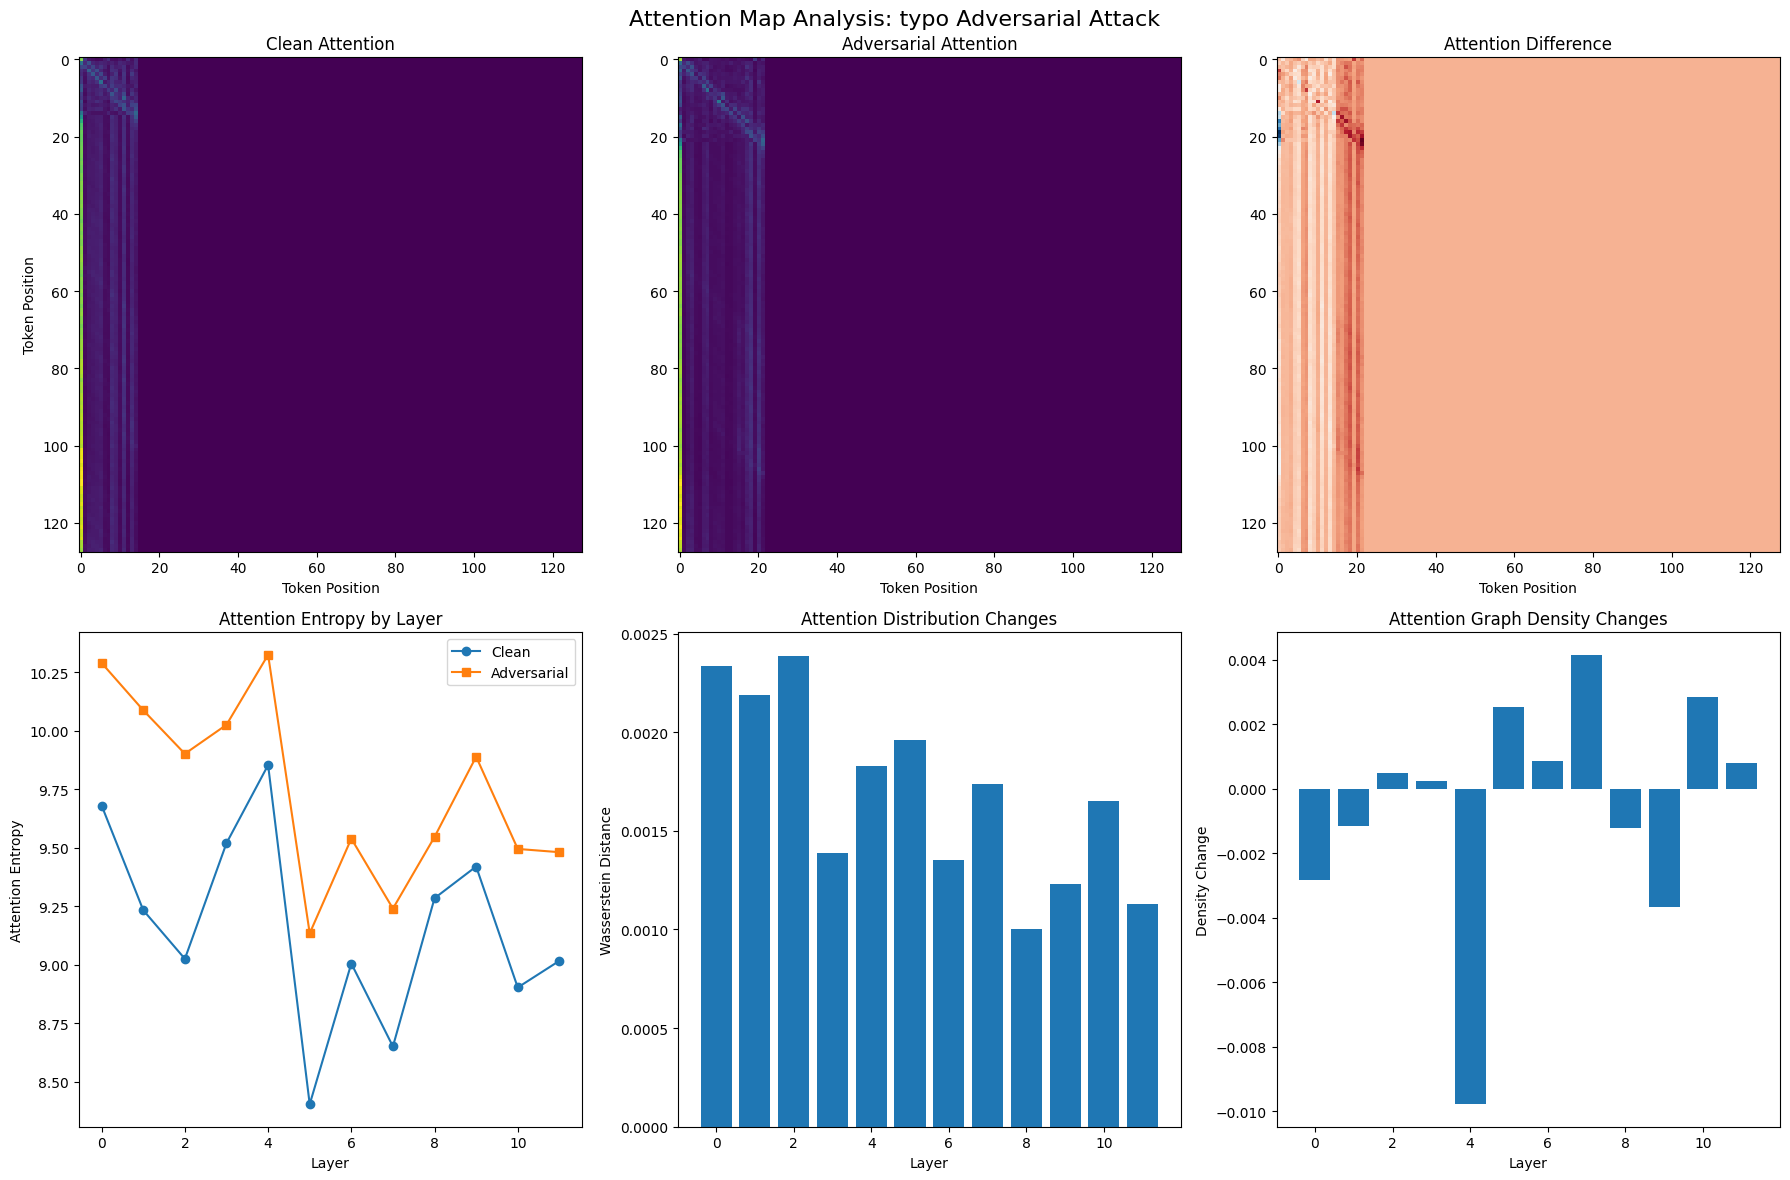


Analyzing synonym adversarial attacks...


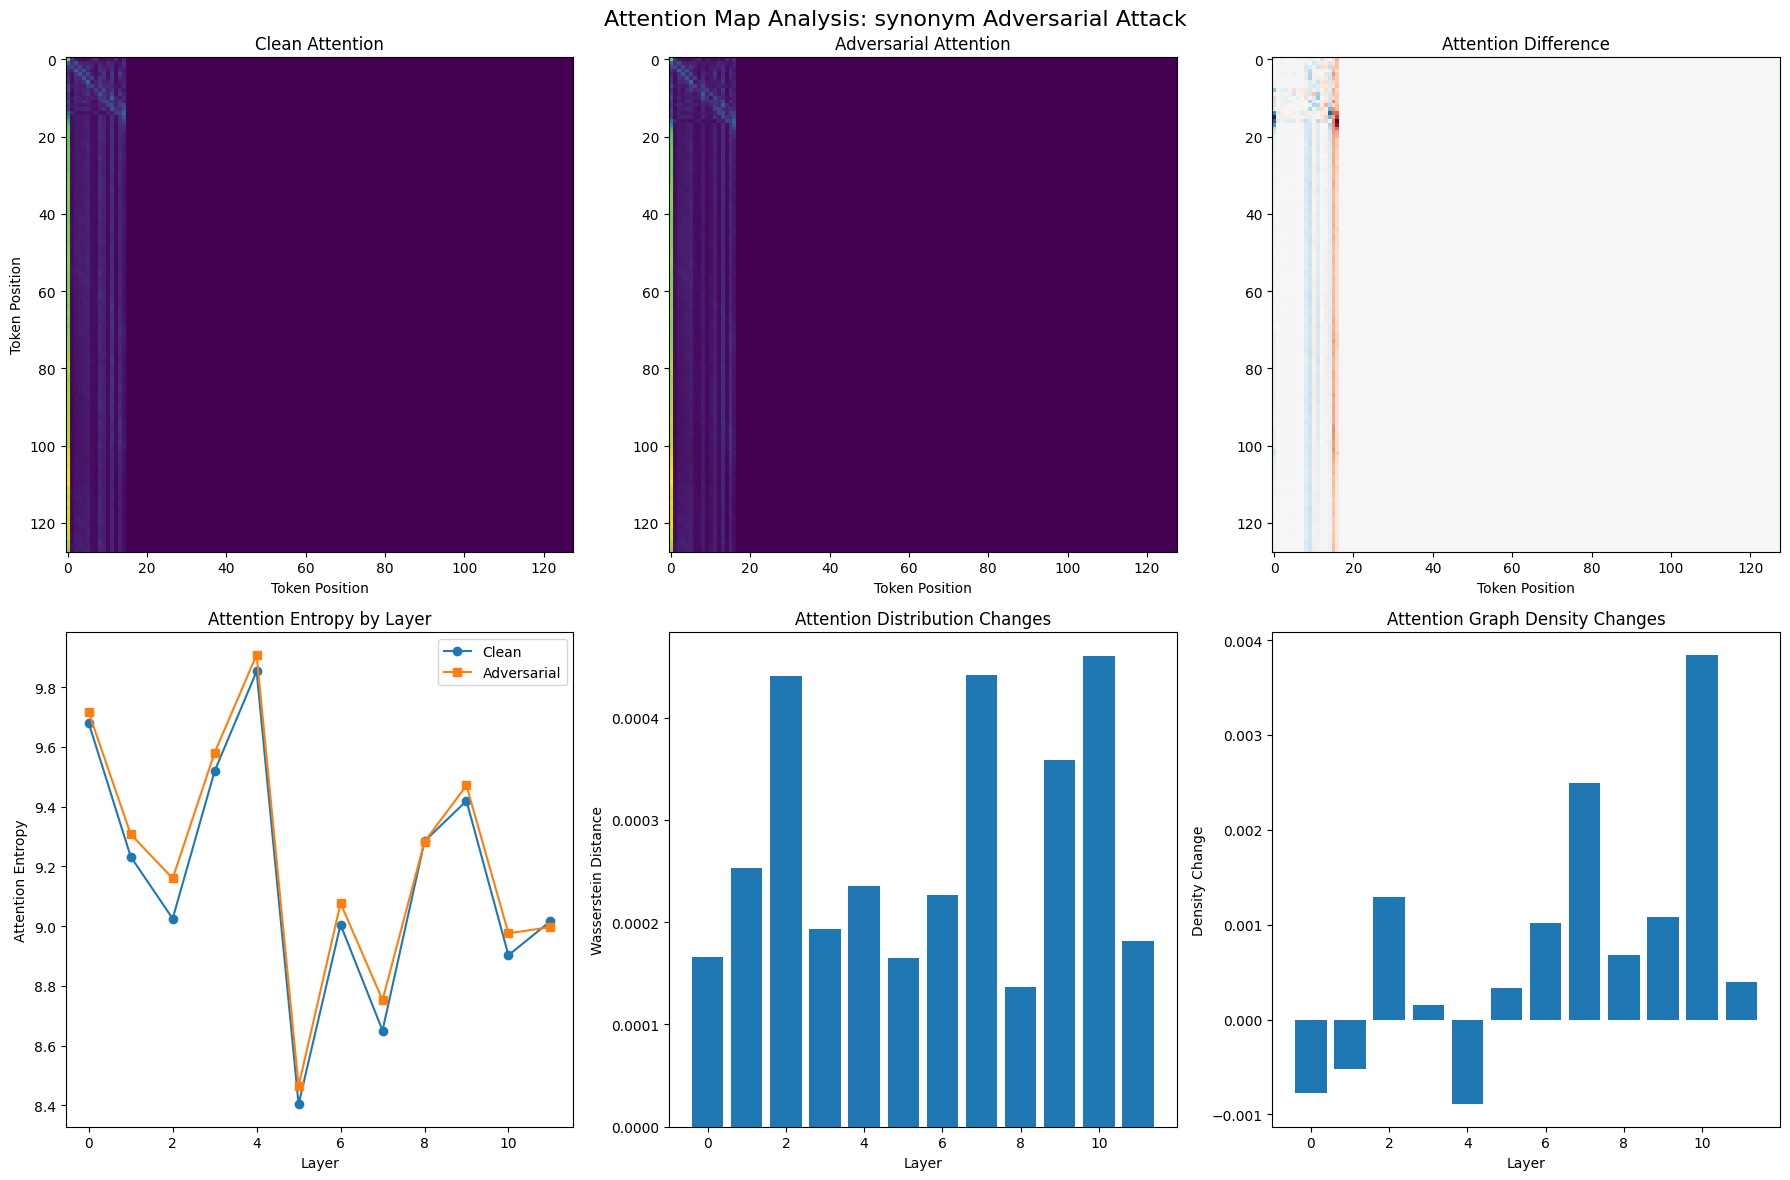

Summary report saved to: demo_analysis_summary.md


In [5]:
# Example usage and testing
def demo_analysis():
    """Demo function to test the analysis pipeline"""
    # Sample texts for analysis
    sample_texts = [
        "The quick brown fox jumps over the lazy dog while chasing a rabbit",
        "Machine learning algorithms require large amounts of training data",
        "Climate change is causing significant environmental transformations worldwide",
        "Natural language processing has revolutionized human computer interactions"
    ]
    
    # Initialize analyzer
    analyzer = AdversarialAttentionAnalyzer("bert-base-uncased")
    
    # Run comprehensive analysis
    results = analyzer.run_comprehensive_analysis(
        sample_texts, 
        methods=['typo', 'synonym'],
        save_prefix="demo_analysis"
    )
    
    return analyzer, results

if __name__ == "__main__":
    analyzer, results = demo_analysis()

In [8]:
###### BUGGY CODE ######
#### JUST FOR REFERENCE ######

class AdversarialAttentionAnalyzer:
    """
    Comprehensive analyzer for studying adversarial effects on LLM attention mechanisms
    """
    
    def __init__(self, model_name: str = "bert-base-uncased", device: str = None):
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        self.model_name = model_name
        
        # Initialize model and tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            
        try:
            self.model = AutoModel.from_pretrained(model_name, output_attentions=True)
        except:
            self.model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions=True)
        
        self.model = self.model.to(self.device)
        self.model.eval()
        
        # Analysis storage
        self.results = {}
        self.attention_data = {}
        
    def generate_adversarial_texts(self, texts: List[str], 
                                 methods: List[str] = ['typo', 'synonym', 'insertion', 'deletion'],
                                 intensity: float = 0.1) -> Dict[str, List[str]]:
        """
        Generate adversarial examples using multiple perturbation strategies
        """
        adversarial_sets = {}
        
        for method in methods:
            adversarial_sets[method] = []
            for text in texts:
                if method == 'typo':
                    adversarial_sets[method].append(self._add_typos(text, intensity))
                elif method == 'synonym':
                    adversarial_sets[method].append(self._replace_synonyms(text, intensity))
                elif method == 'insertion':
                    adversarial_sets[method].append(self._insert_words(text, intensity))
                elif method == 'deletion':
                    adversarial_sets[method].append(self._delete_words(text, intensity))
                elif method == 'reorder':
                    adversarial_sets[method].append(self._reorder_words(text, intensity))
        
        return adversarial_sets
    
    def _add_typos(self, text: str, intensity: float) -> str:
        """Add character-level typos"""
        words = text.split()
        n_typos = max(1, int(len(text) * intensity))
        
        for _ in range(n_typos):
            if len(words) > 0:
                word_idx = np.random.randint(0, len(words))
                word = words[word_idx]
                if len(word) > 2:
                    char_idx = np.random.randint(0, len(word))
                    # Random typo operation: swap, delete, or insert
                    operation = np.random.choice(['swap', 'delete', 'insert'])
                    
                    if operation == 'swap' and len(word) > 1:
                        # Swap adjacent characters
                        swap_idx = min(char_idx, len(word)-2)
                        word = word[:swap_idx] + word[swap_idx+1] + word[swap_idx] + word[swap_idx+2:]
                    elif operation == 'delete' and len(word) > 1:
                        word = word[:char_idx] + word[char_idx+1:]
                    elif operation == 'insert':
                        random_char = chr(np.random.randint(97, 123))
                        word = word[:char_idx] + random_char + word[char_idx:]
                
                words[word_idx] = word
        
        return ' '.join(words)
    
    def _replace_synonyms(self, text: str, intensity: float) -> str:
        """Replace words with synonyms using WordNet"""
        try:
            from nltk.corpus import wordnet as wn
            import nltk
            
            words = text.split()
            n_replacements = max(1, int(len(words) * intensity))
            
            for _ in range(n_replacements):
                if len(words) > 0:
                    word_idx = np.random.randint(0, len(words))
                    word = words[word_idx].lower()
                    
                    synonyms = set()
                    for syn in wn.synsets(word):
                        for lemma in syn.lemmas():
                            synonym = lemma.name().replace('_', ' ')
                            if synonym != word and len(synonym.split()) == 1:
                                synonyms.add(synonym)
                    
                    if synonyms:
                        new_word = np.random.choice(list(synonyms))
                        words[word_idx] = new_word
            
            return ' '.join(words)
        except:
            return text  # Fallback if WordNet fails
    
    def _insert_words(self, text: str, intensity: float) -> str:
        """Insert random words"""
        words = text.split()
        n_insertions = max(1, int(len(words) * intensity))
        filler_words = ['the', 'a', 'and', 'or', 'but', 'very', 'quite', 'somewhat']
        
        for _ in range(n_insertions):
            if len(words) > 0:
                insert_idx = np.random.randint(0, len(words))
                insert_word = np.random.choice(filler_words)
                words.insert(insert_idx, insert_word)
        
        return ' '.join(words)
    
    def _delete_words(self, text: str, intensity: float) -> str:
        """Delete random words"""
        words = text.split()
        n_deletions = max(1, int(len(words) * intensity))
        
        for _ in range(n_deletions):
            if len(words) > 1:  # Keep at least one word
                delete_idx = np.random.randint(0, len(words))
                words.pop(delete_idx)
        
        return ' '.join(words)
    
    def _reorder_words(self, text: str, intensity: float) -> str:
        """Reorder words in the text"""
        words = text.split()
        if len(words) > 2:
            n_swaps = max(1, int(len(words) * intensity))
            
            for _ in range(n_swaps):
                idx1, idx2 = np.random.choice(len(words), 2, replace=False)
                words[idx1], words[idx2] = words[idx2], words[idx1]
        
        return ' '.join(words)
    
    def extract_attention_maps(self, texts: List[str], layer_idx: int = None) -> Dict:
        """
        Extract attention maps from the model
        """
        attention_data = {
            'all_attention': [],  # All attention heads across layers
            'layer_attention': {},  # Attention organized by layer
            'token_pairs': [],  # Token pairs and their attention weights
            'cls_attention': []  # CLS token attention patterns
        }
        
        with torch.no_grad():
            for text in texts:
                inputs = self.tokenizer(text, return_tensors="pt", truncation=True, 
                                      max_length=512, padding=True).to(self.device)
                
                outputs = self.model(**inputs, output_attentions=True)
                attentions = outputs.attentions  # Tuple of layer attention tensors
                
                # Store all attention maps
                batch_attention = []
                for layer, attn in enumerate(attentions):
                    # attn shape: (batch_size, num_heads, seq_len, seq_len)
                    attn_matrix = attn[0].cpu().numpy()  # Remove batch dimension
                    batch_attention.append(attn_matrix)
                    
                    # Store by layer if requested
                    if layer_idx is None or layer == layer_idx:
                        if layer not in attention_data['layer_attention']:
                            attention_data['layer_attention'][layer] = []
                        attention_data['layer_attention'][layer].append(attn_matrix)
                
                attention_data['all_attention'].append(batch_attention)
                
                # Extract CLS token attention patterns
                cls_attention = self._extract_cls_attention(batch_attention)
                attention_data['cls_attention'].append(cls_attention)
                
                # Extract token pair attention
                token_pairs = self._extract_token_pairs(batch_attention, inputs, text)
                attention_data['token_pairs'].extend(token_pairs)
        
        return attention_data
    
    def _extract_cls_attention(self, attention_maps: List[np.ndarray]) -> Dict:
        """Extract attention patterns related to CLS token"""
        cls_attention = {}
        
        for layer, attn in enumerate(attention_maps):
            # Attention from CLS token to all other tokens (average across heads)
            cls_to_all = attn[:, 0, :].mean(axis=0)  # Average over heads
            # Attention from all tokens to CLS token
            all_to_cls = attn[:, :, 0].mean(axis=0)  # Average over heads
            
            cls_attention[layer] = {
                'cls_to_all': cls_to_all,
                'all_to_cls': all_to_cls
            }
        
        return cls_attention
    
    def _extract_token_pairs(self, attention_maps: List[np.ndarray], 
                           inputs: Dict, text: str) -> List[Dict]:
        """Extract attention weights for important token pairs"""
        tokens = self.tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
        token_pairs = []
        
        # Focus on meaningful token pairs (excluding special tokens)
        special_tokens = [self.tokenizer.cls_token, self.tokenizer.sep_token, 
                         self.tokenizer.pad_token, '[CLS]', '[SEP]', '[PAD]']
        meaningful_tokens = [i for i, token in enumerate(tokens) 
                           if token not in special_tokens and not token.startswith('##')]
        
        if len(meaningful_tokens) < 2:
            return token_pairs
        
        for layer, attn in enumerate(attention_maps):
            # Average attention across heads
            avg_attn = attn.mean(axis=0)
            
            for i in range(len(meaningful_tokens)):
                for j in range(i+1, len(meaningful_tokens)):
                    token_i_idx = meaningful_tokens[i]
                    token_j_idx = meaningful_tokens[j]
                    
                    attention_weight = avg_attn[token_i_idx, token_j_idx]
                    
                    token_pairs.append({
                        'layer': layer,
                        'token_i': tokens[token_i_idx],
                        'token_j': tokens[token_j_idx],
                        'token_i_idx': token_i_idx,
                        'token_j_idx': token_j_idx,
                        'attention': attention_weight,
                        'text': text
                    })
        
        return token_pairs
    
    def compute_attention_metrics(self, clean_attention: Dict, adv_attention: Dict) -> Dict:
        """
        Compute quantitative metrics comparing clean and adversarial attention maps
        """
        metrics = {}
        
        # 1. Attention distribution changes
        metrics['distribution_changes'] = self._compare_attention_distributions(
            clean_attention, adv_attention)
        
        # 2. Attention entropy changes
        metrics['entropy_changes'] = self._compute_entropy_changes(
            clean_attention, adv_attention)
        
        # 3. Topological analysis of attention graphs
        metrics['topological_changes'] = self._analyze_attention_topology(
            clean_attention, adv_attention)
        
        # 4. Attention focus shifts
        metrics['focus_shifts'] = self._compute_focus_shifts(
            clean_attention, adv_attention)
        
        return metrics
    
    def _compare_attention_distributions(self, clean: Dict, adv: Dict) -> Dict:
        """Compare attention weight distributions using statistical tests"""
        distribution_metrics = {}
        
        for layer in clean['layer_attention'].keys():
            if layer in adv['layer_attention']:
                clean_attn = np.concatenate([a.mean(axis=0).flatten() 
                                           for a in clean['layer_attention'][layer]])
                adv_attn = np.concatenate([a.mean(axis=0).flatten() 
                                         for a in adv['layer_attention'][layer]])
                
                # KS test for distribution similarity
                ks_stat, ks_p = stats.ks_2samp(clean_attn, adv_attn)
                
                # Wasserstein distance
                wasserstein_dist = stats.wasserstein_distance(clean_attn, adv_attn)
                
                distribution_metrics[layer] = {
                    'ks_statistic': ks_stat,
                    'ks_pvalue': ks_p,
                    'wasserstein_distance': wasserstein_dist,
                    'mean_change': np.mean(adv_attn) - np.mean(clean_attn),
                    'std_change': np.std(adv_attn) - np.std(clean_attn)
                }
        
        return distribution_metrics
    
    def _compute_entropy_changes(self, clean: Dict, adv: Dict) -> Dict:
        """Compute changes in attention entropy"""
        entropy_metrics = {}
        
        def attention_entropy(attention_map):
            """Compute normalized entropy of attention distribution"""
            # Flatten and normalize to probability distribution
            attn_flat = attention_map.flatten()
            attn_flat = attn_flat / attn_flat.sum()
            # Remove zeros for entropy calculation
            attn_flat = attn_flat[attn_flat > 0]
            return -np.sum(attn_flat * np.log2(attn_flat))
        
        for layer in clean['layer_attention'].keys():
            if layer in adv['layer_attention']:
                clean_entropies = [attention_entropy(a.mean(axis=0)) 
                                 for a in clean['layer_attention'][layer]]
                adv_entropies = [attention_entropy(a.mean(axis=0)) 
                               for a in adv['layer_attention'][layer]]
                
                entropy_metrics[layer] = {
                    'mean_clean_entropy': np.mean(clean_entropies),
                    'mean_adv_entropy': np.mean(adv_entropies),
                    'entropy_change': np.mean(adv_entropies) - np.mean(clean_entropies),
                    'entropy_ratio': np.mean(adv_entropies) / np.mean(clean_entropies)
                }
        
        return entropy_metrics
    
    def _analyze_attention_topology(self, clean: Dict, adv: Dict) -> Dict:
        """Analyze topological properties of attention graphs"""
        topological_metrics = {}
        
        for layer in clean['layer_attention'].keys():
            if layer in adv['layer_attention']:
                clean_graphs = [self._attention_to_graph(a.mean(axis=0)) 
                              for a in clean['layer_attention'][layer]]
                adv_graphs = [self._attention_to_graph(a.mean(axis=0)) 
                            for a in adv['layer_attention'][layer]]
                
                # Compute graph properties
                clean_props = [self._compute_graph_properties(g) for g in clean_graphs]
                adv_props = [self._compute_graph_properties(g) for g in adv_graphs]
                
                # Average properties across examples
                avg_clean = {k: np.mean([p[k] for p in clean_props]) 
                           for k in clean_props[0].keys()}
                avg_adv = {k: np.mean([p[k] for p in adv_props]) 
                         for k in adv_props[0].keys()}
                
                topological_metrics[layer] = {
                    'clean_properties': avg_clean,
                    'adv_properties': avg_adv,
                    'property_changes': {k: avg_adv[k] - avg_clean[k] 
                                       for k in avg_clean.keys()}
                }
        
        return topological_metrics
    
    def _attention_to_graph(self, attention_matrix: np.ndarray, threshold: float = 0.1) -> nx.Graph:
        """Convert attention matrix to graph"""
        G = nx.Graph()
        n_nodes = attention_matrix.shape[0]
        
        # Add nodes
        for i in range(n_nodes):
            G.add_node(i)
        
        # Add edges based on attention threshold
        for i in range(n_nodes):
            for j in range(n_nodes):
                if i != j and attention_matrix[i, j] > threshold:
                    G.add_edge(i, j, weight=attention_matrix[i, j])
        
        return G
    
    def _compute_graph_properties(self, G: nx.Graph) -> Dict:
        """Compute various graph properties"""
        properties = {}
        
        if len(G.nodes) == 0:
            return {k: 0 for k in ['density', 'avg_degree', 'avg_clustering', 
                                  'avg_path_length', 'diameter']}
        
        properties['density'] = nx.density(G)
        properties['avg_degree'] = np.mean([d for n, d in G.degree()])
        properties['avg_clustering'] = nx.average_clustering(G)
        
        # For connected components
        if nx.is_connected(G):
            properties['avg_path_length'] = nx.average_shortest_path_length(G)
            properties['diameter'] = nx.diameter(G)
        else:
            # For disconnected graphs, compute for largest component
            largest_cc = max(nx.connected_components(G), key=len)
            subgraph = G.subgraph(largest_cc)
            if len(subgraph.nodes) > 1:
                properties['avg_path_length'] = nx.average_shortest_path_length(subgraph)
                properties['diameter'] = nx.diameter(subgraph)
            else:
                properties['avg_path_length'] = 0
                properties['diameter'] = 0
        
        return properties
    
    def _compute_focus_shifts(self, clean: Dict, adv: Dict) -> Dict:
        """Compute how attention focus shifts between tokens"""
        focus_metrics = {}
        
        for layer in clean['layer_attention'].keys():
            if layer in adv['layer_attention']:
                clean_attn = np.mean([a.mean(axis=0) for a in clean['layer_attention'][layer]], axis=0)
                adv_attn = np.mean([a.mean(axis=0) for a in adv['layer_attention'][layer]], axis=0)
                
                # Compute attention shift matrix
                shift_matrix = adv_attn - clean_attn
                
                # Maximum attention increase and decrease
                max_increase = np.max(shift_matrix)
                max_decrease = np.min(shift_matrix)
                
                # Overall shift magnitude
                shift_magnitude = np.linalg.norm(shift_matrix)
                
                focus_metrics[layer] = {
                    'max_attention_increase': max_increase,
                    'max_attention_decrease': max_decrease,
                    'shift_magnitude': shift_magnitude,
                    'shift_matrix': shift_matrix
                }
        
        return focus_metrics
    
    def visualize_attention_comparison(self, clean_attention: Dict, adv_attention: Dict, 
                                     method: str, save_path: str = None):
        """Create comprehensive visualizations of attention changes"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'Attention Map Analysis: {method} Adversarial Attack', fontsize=16)
        
        # 1. Attention distribution comparison
        layer = list(clean_attention['layer_attention'].keys())[0]
        clean_attn = clean_attention['layer_attention'][layer][0].mean(axis=0)
        adv_attn = adv_attention['layer_attention'][layer][0].mean(axis=0)
        
        axes[0, 0].imshow(clean_attn, cmap='viridis', aspect='auto')
        axes[0, 0].set_title('Clean Attention')
        axes[0, 0].set_xlabel('Token Position')
        axes[0, 0].set_ylabel('Token Position')
        
        axes[0, 1].imshow(adv_attn, cmap='viridis', aspect='auto')
        axes[0, 1].set_title('Adversarial Attention')
        axes[0, 1].set_xlabel('Token Position')
        
        axes[0, 2].imshow(adv_attn - clean_attn, cmap='RdBu_r', aspect='auto')
        axes[0, 2].set_title('Attention Difference')
        axes[0, 2].set_xlabel('Token Position')
        
        # 2. Layer-wise metric comparisons
        metrics = self.compute_attention_metrics(clean_attention, adv_attention)
        
        # Entropy changes
        layers = list(metrics['entropy_changes'].keys())
        clean_entropies = [metrics['entropy_changes'][l]['mean_clean_entropy'] for l in layers]
        adv_entropies = [metrics['entropy_changes'][l]['mean_adv_entropy'] for l in layers]
        
        axes[1, 0].plot(layers, clean_entropies, 'o-', label='Clean')
        axes[1, 0].plot(layers, adv_entropies, 's-', label='Adversarial')
        axes[1, 0].set_xlabel('Layer')
        axes[1, 0].set_ylabel('Attention Entropy')
        axes[1, 0].legend()
        axes[1, 0].set_title('Attention Entropy by Layer')
        
        # Distribution changes (Wasserstein distance)
        wasserstein_dists = [metrics['distribution_changes'][l]['wasserstein_distance'] 
                           for l in layers]
        axes[1, 1].bar(layers, wasserstein_dists)
        axes[1, 1].set_xlabel('Layer')
        axes[1, 1].set_ylabel('Wasserstein Distance')
        axes[1, 1].set_title('Attention Distribution Changes')
        
        # Graph density changes
        density_changes = [metrics['topological_changes'][l]['property_changes']['density'] 
                         for l in layers]
        axes[1, 2].bar(layers, density_changes)
        axes[1, 2].set_xlabel('Layer')
        axes[1, 2].set_ylabel('Density Change')
        axes[1, 2].set_title('Attention Graph Density Changes')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def run_comprehensive_analysis(self, texts: List[str], 
                                 methods: List[str] = None,
                                 save_prefix: str = "analysis"):
        """
        Run complete analysis pipeline
        """
        if methods is None:
            methods = ['typo', 'synonym', 'insertion', 'deletion']
        
        print("Extracting clean attention maps...")
        clean_attention = self.extract_attention_maps(texts)
        
        results = {}
        
        for method in methods:
            print(f"\nAnalyzing {method} adversarial attacks...")
            
            # Generate adversarial texts
            adv_texts = self.generate_adversarial_texts(texts, methods=[method])[method]
            
            # Extract adversarial attention maps
            adv_attention = self.extract_attention_maps(adv_texts)
            
            # Compute metrics
            metrics = self.compute_attention_metrics(clean_attention, adv_attention)
            
            # Store results
            results[method] = {
                'adversarial_texts': adv_texts,
                'attention_maps': adv_attention,
                'metrics': metrics,
                'timestamp': datetime.now().isoformat()
            }
            
            # Create visualizations
            self.visualize_attention_comparison(
                clean_attention, adv_attention, method,
                f"{save_prefix}_{method}_comparison.png"
            )
        
        # Store comprehensive results
        self.results = results
        with open(f"{save_prefix}_results.pkl", "wb") as f:
            pickle.dump(results, f)
        
        # Generate summary report
        self.generate_summary_report(results, f"{save_prefix}_summary.md")
        
        return results
    
    def generate_summary_report(self, results: Dict, save_path: str):
        """Generate Markdown summary report"""
        report = ["# Adversarial Attention Analysis Report", ""]
        report.append(f"**Model**: {self.model_name}")
        report.append(f"**Date**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        report.append("")
        
        for method, data in results.items():
            report.append(f"## {method.upper()} Attack Analysis")
            report.append("")
            
            metrics = data['metrics']
            
            # Key findings
            report.append("### Key Metrics")
            report.append("| Layer | Entropy Change | Wasserstein Distance | Graph Density Change |")
            report.append("|-------|----------------|---------------------|---------------------|")
            
            for layer in metrics['entropy_changes'].keys():
                entropy_change = metrics['entropy_changes'][layer]['entropy_change']
                wasserstein = metrics['distribution_changes'][layer]['wasserstein_distance']
                density_change = metrics['topological_changes'][layer]['property_changes']['density']
                
                report.append(f"| {layer} | {entropy_change:.4f} | {wasserstein:.4f} | {density_change:.4f} |")
            
            report.append("")
            
            # Summary statistics
            avg_entropy_change = np.mean([m['entropy_change'] 
                                        for m in metrics['entropy_changes'].values()])
            avg_wasserstein = np.mean([m['wasserstein_distance'] 
                                     for m in metrics['distribution_changes'].values()])
            
            report.append(f"**Average Entropy Change**: {avg_entropy_change:.4f}")
            report.append(f"**Average Distribution Change**: {avg_wasserstein:.4f}")
            report.append("")
        
        with open(save_path, 'w') as f:
            f.write('\n'.join(report))
        
        print(f"Summary report saved to: {save_path}")